In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm
#import seaborn as sns
from scipy.stats import norm

In [2]:
# import tensorflow as tf
# print(tf.__version__)

In [3]:
# from tensorflow.python.client import device_lib

# print(device_lib.list_local_devices())

In [4]:
from sklearn import cluster

if hasattr(cluster, 'KMeans') and hasattr(cluster.KMeans, 'n_features_in_'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


In [5]:
bridge2 = pd.read_csv('/Users/jeiloh/jupyter/Wallercreek/data/Bridge 2 Depth-data-2023-05-17 12_01_13.csv')
bridge3 = pd.read_csv('/Users/jeiloh/jupyter/Wallercreek/data/Bridge 3 Depth-data-2023-05-17 12_01_21.csv')
bridge4 = pd.read_csv('/Users/jeiloh/jupyter/Wallercreek/data/Bridge 4 Depth-data-2023-05-17 12_01_28.csv')
bridge5 = pd.read_csv('/Users/jeiloh/jupyter/Wallercreek/data/Bridge 5 Depth-data-2023-05-17 12_01_38.csv')

In [6]:
#rainfall = pd.read_csv('WallerCreekat23rdStreet_rain.csv')

In [7]:
#rainfall['Time'] = pd.to_datetime(rainfall['Date - Time'])

In [8]:
#rainfall = rainfall.set_index('Time')
#rainfall = rainfall.resample('1min').sum()['Rain(inches)'].interpolate()

In [9]:
bridge2['Time'] = pd.to_datetime(bridge2['Time'])
bridge3['Time'] = pd.to_datetime(bridge3['Time'])
bridge4['Time'] = pd.to_datetime(bridge4['Time'])
bridge5['Time'] = pd.to_datetime(bridge5['Time'])

In [10]:
bridge2 = bridge2.set_index('Time')
bridge3 = bridge3.set_index('Time')
bridge4 = bridge4.set_index('Time')
bridge5 = bridge5.set_index('Time')

In [11]:
#bridge2 = bridge2.resample('15min').mean()['depth.mean'].interpolate()
#bridge3 = bridge3.resample('15min').mean()['depth.mean'].interpolate()
#bridge4 = bridge4.resample('15min').mean()['depth.mean'].interpolate()
#bridge5 = bridge5.resample('15min').mean()['depth.mean'].interpolate()

In [12]:
# b2 = bridge2['2022-08-17':'2023-03-18']
# b3 = bridge3['2022-08-17':'2023-03-18']
# b4 = bridge4['2022-08-17':'2023-03-18']
# b5 = bridge5['2022-08-17':'2023-03-18']

In [13]:
b2 = bridge2
b3 = bridge3
b4 = bridge4
b5 = bridge5

In [14]:
#rainfall = rainfall.reindex(b2.index, method='nearest')

In [15]:
#rain = rainfall

# RAW data

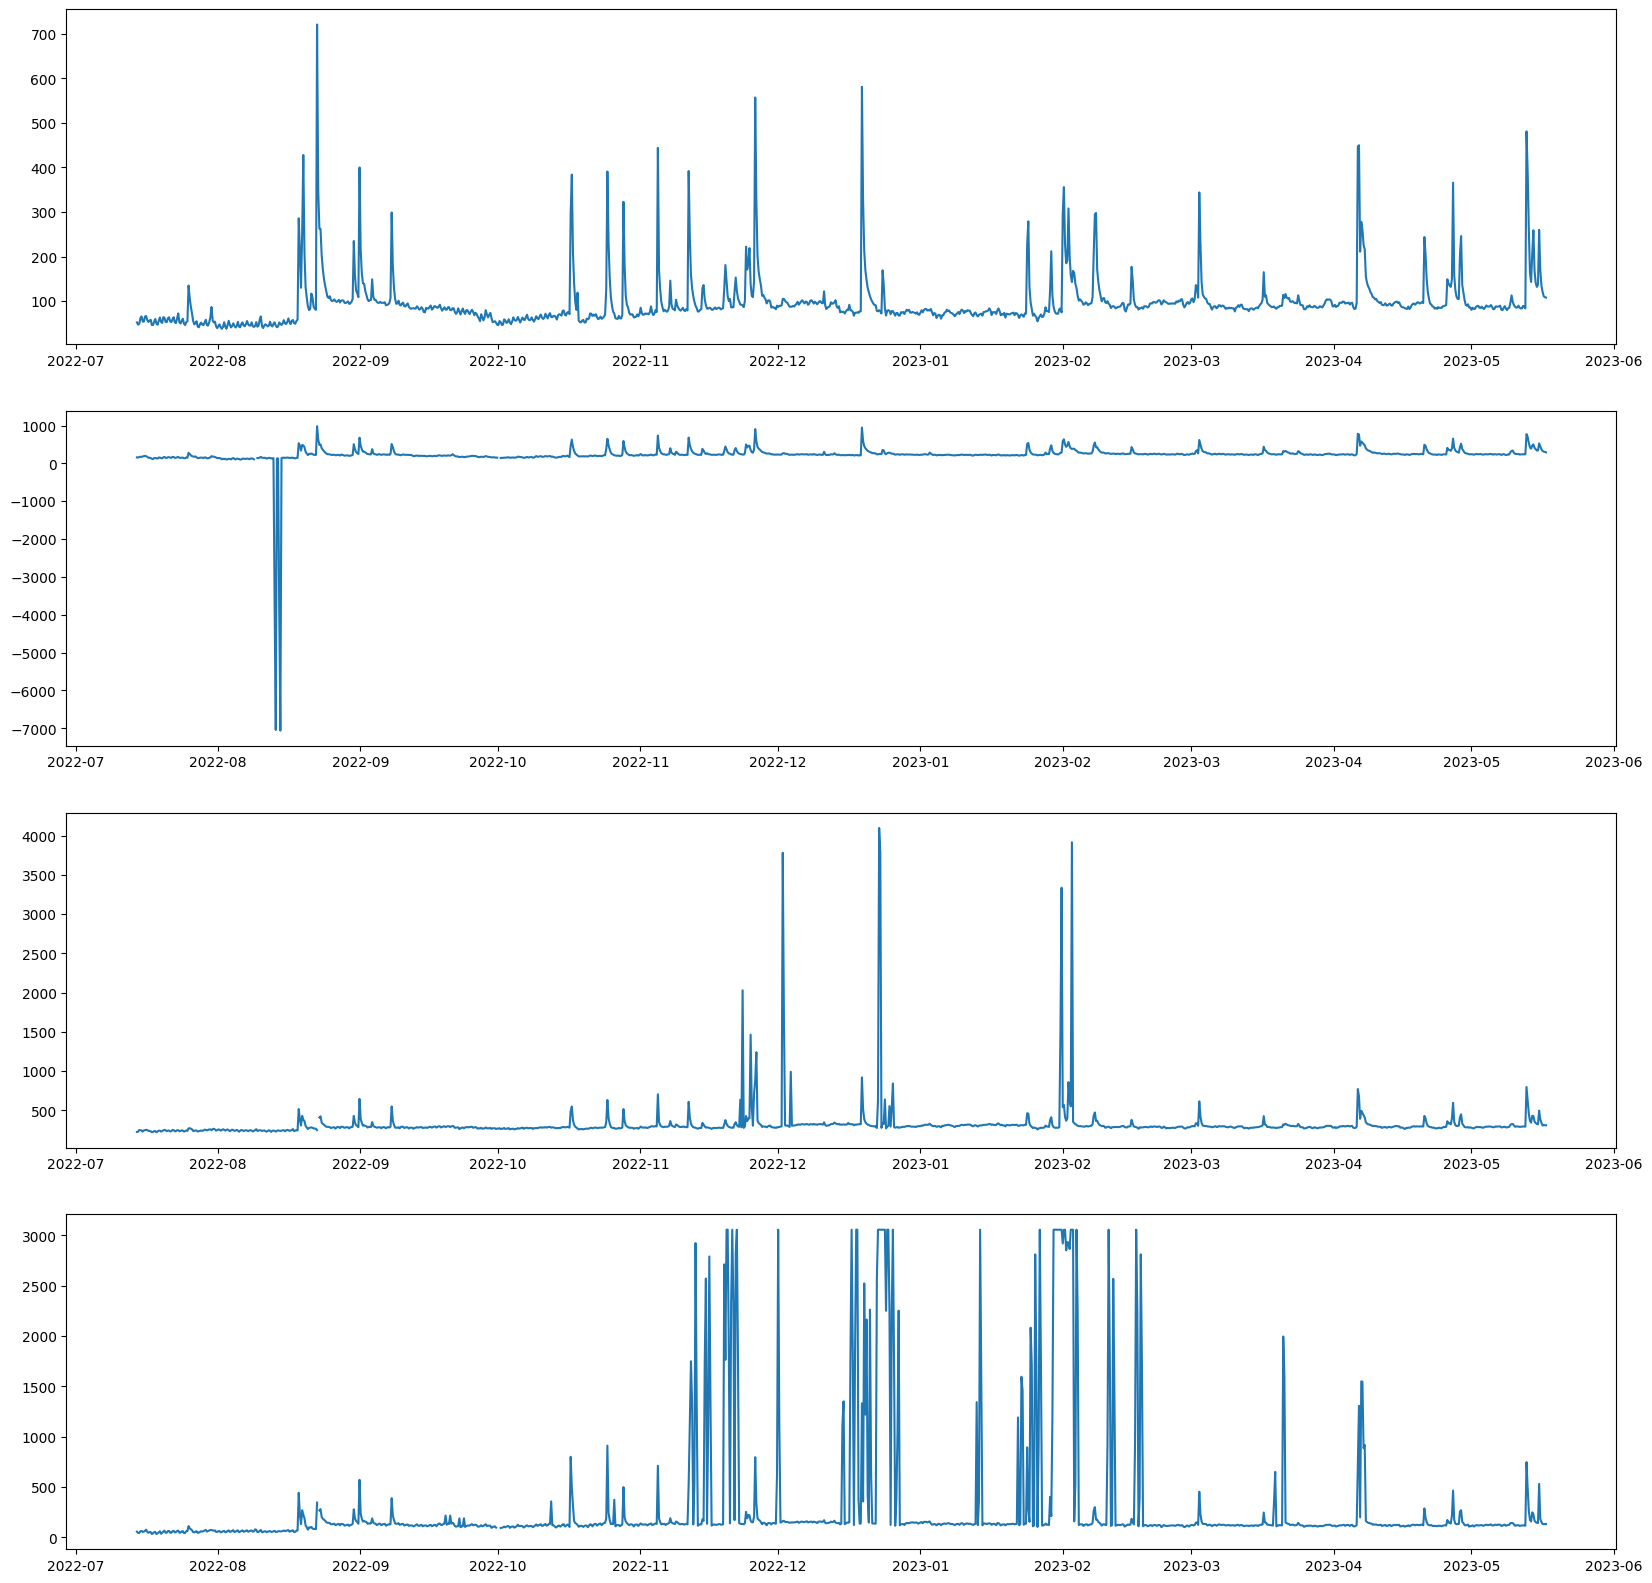

In [16]:
fig, ax = plt.subplots(4, 1, figsize=(20, 20))
#ax[0].plot(rain)
ax[0].plot(b2)
ax[1].plot(b3)
ax[2].plot(b4)
ax[3].plot(b5)

In [17]:
b2 = b2.resample('6h').mean().interpolate()
b3 = b3.resample('6h').mean().interpolate()
b4 = b4.resample('6h').mean().interpolate()
b5 = b5.resample('6h').mean().interpolate()
#rain = rain.resample('6h').sum().interpolate()

In [18]:
# fig, ax1 = plt.subplots()
# ax1.plot(rain)
# ax2 = ax1.twinx()
# ax2.plot(b3, color='tab:orange')

In [19]:
concatenated = pd.concat([b2, b3, b4, b5], axis=1)
concatenated = concatenated.set_index(b2.index)

# interpolate using the index method
interpolated = concatenated.interpolate(method='index')

In [20]:
df = interpolated
df.columns = ['bridge2', 'bridge3', 'bridge4', 'bridge5']
df

,bridge2,bridge3,bridge4,bridge5
Time,,,,
2022-07-14 06:00:00,52.3,158.0,226.0,56.5
2022-07-14 12:00:00,47.2,151.0,229.0,43.8
2022-07-14 18:00:00,48.9,172.0,250.0,43.6
2022-07-15 00:00:00,61.4,172.0,247.0,58.9
2022-07-15 06:00:00,65.7,174.0,245.0,63.8
...,...,...,...,...
2023-05-16 06:00:00,135.0,372.0,341.0,153.0
2023-05-16 12:00:00,121.0,329.0,308.0,132.0
2023-05-16 18:00:00,111.0,309.0,313.0,132.0


In [21]:
df = df * 0.1
df = df.round(1)
#df['rain'] = df['rain']*10
df

,bridge2,bridge3,bridge4,bridge5
Time,,,,
2022-07-14 06:00:00,5.2,15.8,22.6,5.6
2022-07-14 12:00:00,4.7,15.1,22.9,4.4
2022-07-14 18:00:00,4.9,17.2,25.0,4.4
2022-07-15 00:00:00,6.1,17.2,24.7,5.9
2022-07-15 06:00:00,6.6,17.4,24.5,6.4
...,...,...,...,...
2023-05-16 06:00:00,13.5,37.2,34.1,15.3
2023-05-16 12:00:00,12.1,32.9,30.8,13.2
2023-05-16 18:00:00,11.1,30.9,31.3,13.2


In [22]:
df = df['2022-08-24':'2023-05-17']

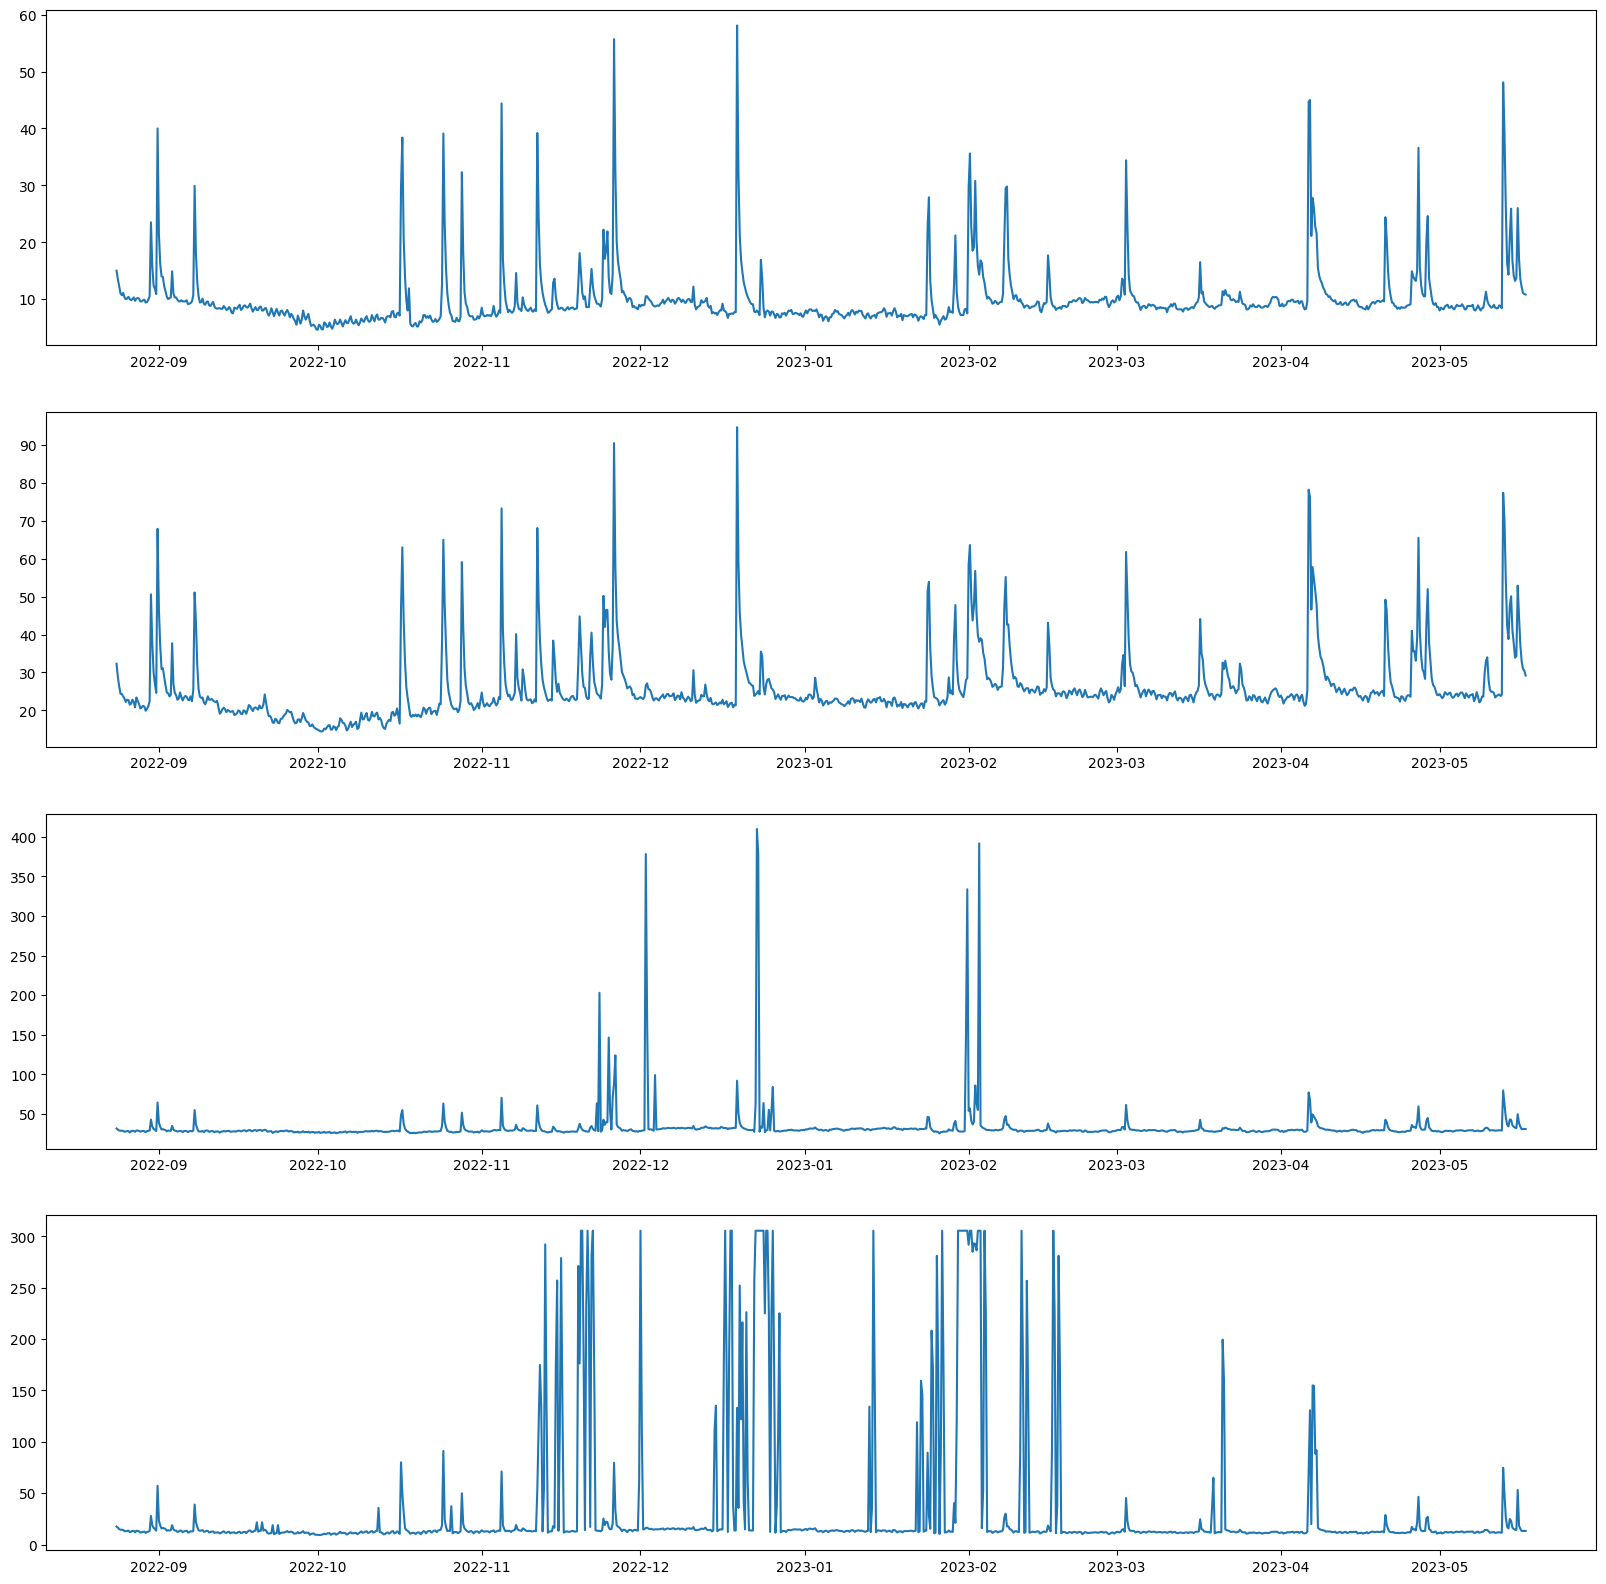

In [23]:
fig, ax = plt.subplots(4, 1, figsize=(20, 20))

ax[0].plot(df.index, df['bridge2'])
ax[1].plot(df['bridge3'])
ax[2].plot(df['bridge4'])
ax[3].plot(df['bridge5'])

# Outlier detection

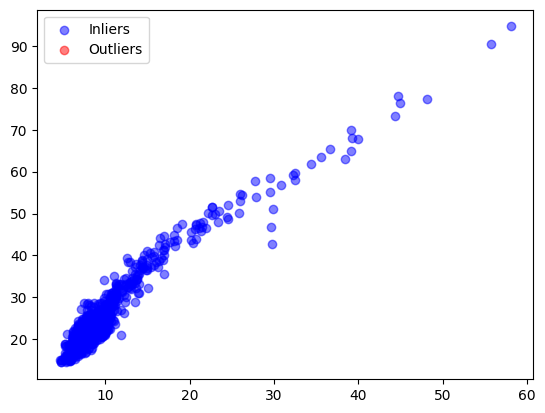

In [24]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(residual_threshold=70, random_state = 0)

# X = df['bridge2'].values.reshape(-1, 1)
# y = df['bridge3'].values.reshape(-1, 1)
features = ['bridge2']
#features = ['bridge2','bridge3']
outputs = ['bridge3']
#outputs = ['bridge5']

X = df[features]
y = df[outputs]
ransac.fit(X, y)

inliers_mask = ransac.inlier_mask_
outliers_mask = np.logical_not(inliers_mask)

plt.scatter(X[inliers_mask], y[inliers_mask], c='blue', alpha=0.5,
            label='Inliers')
plt.scatter(X[outliers_mask], y[outliers_mask], c='red', alpha=0.5,
            label='Outliers')
plt.legend(loc='best')
plt.show()

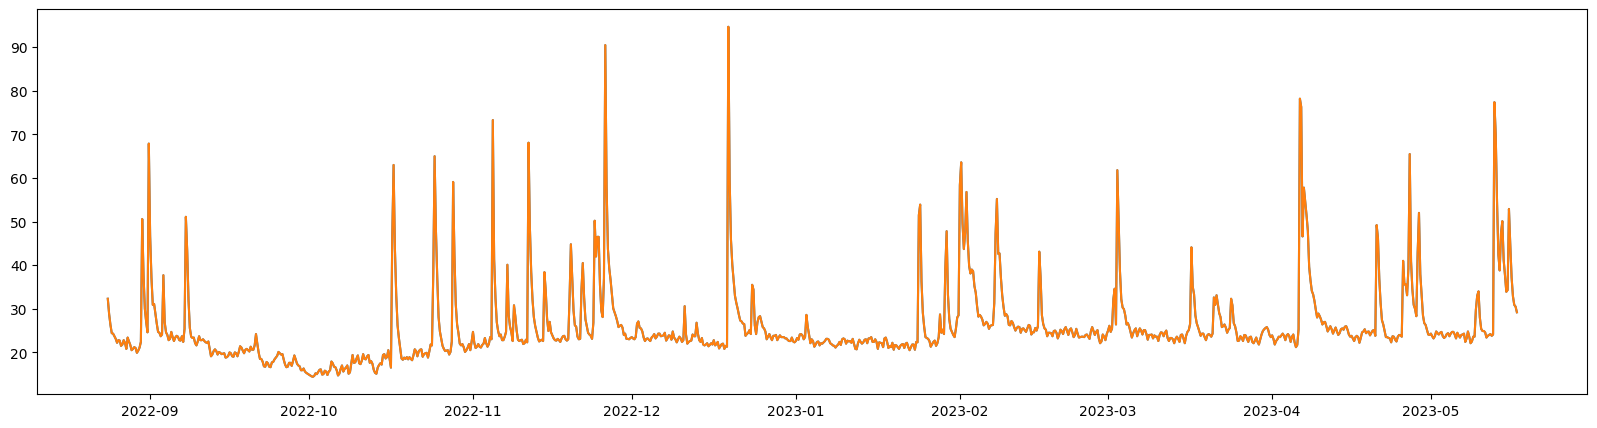

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(df['bridge3'])
ax.plot(y.index[inliers_mask], y['bridge3'][inliers_mask])
ax.scatter(y.index[outliers_mask], y['bridge3'][outliers_mask])

Text(0.5, 0, 'Sensor 4')

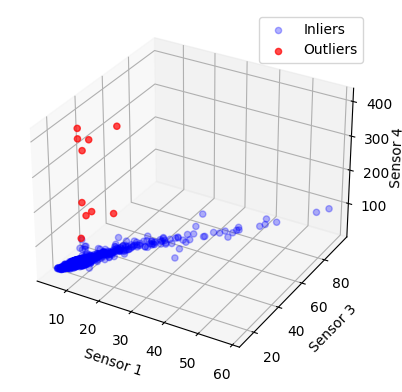

In [26]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(residual_threshold=70, random_state = 0)

features = ['bridge2','bridge3']
outputs = ['bridge4']

X = df[features]
y4 = df[outputs]

ransac.fit(X, y4)

inliers_mask4 = ransac.inlier_mask_
outliers_mask4 = np.logical_not(inliers_mask4)

fig = plt.figure(figsize =(6,6))
plt.subplots_adjust(bottom=0.2, left=0.1, right=0.9, top=0.8)
ax = fig.add_subplot(projection='3d')

ax.scatter(X['bridge2'][inliers_mask4], X['bridge3'][inliers_mask4], y4['bridge4'][inliers_mask4], c='blue', alpha=0.3,
            label='Inliers')
ax.scatter(X['bridge2'][outliers_mask4], X['bridge3'][outliers_mask4], y4['bridge4'][outliers_mask4], c='red', alpha=0.7,
            label='Outliers')
ax.legend(loc='best')
ax.set_xlabel('Sensor 1')
ax.set_ylabel('Sensor 3')
ax.set_zlabel('Sensor 4', labelpad=0.01)

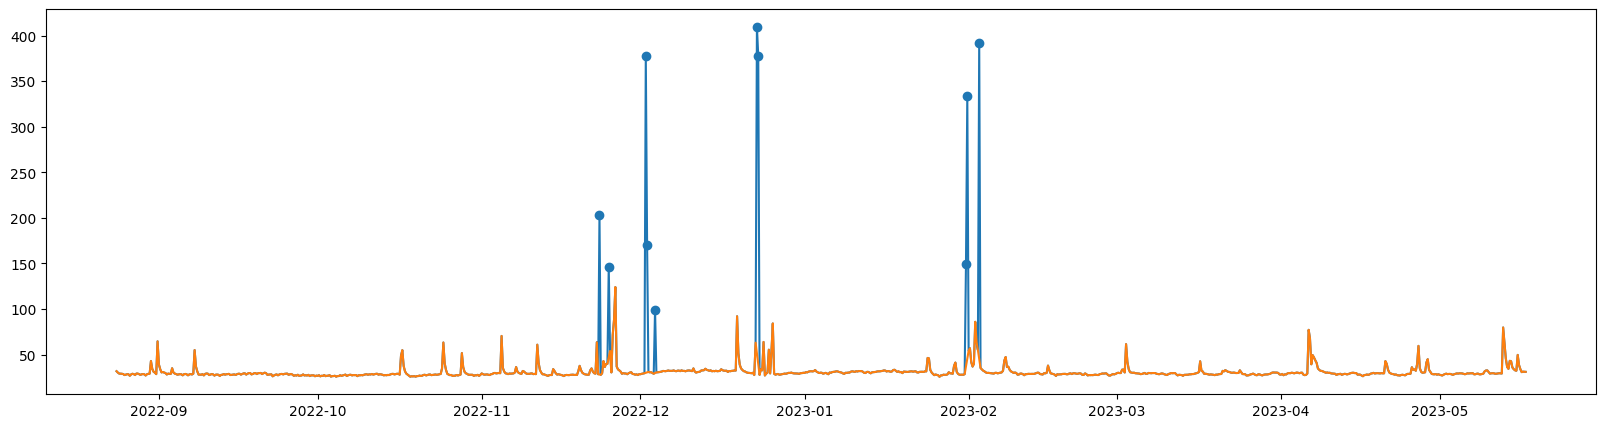

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(df['bridge4'])
ax.plot(y.index[inliers_mask4], y4['bridge4'][inliers_mask4])
ax.scatter(y.index[outliers_mask4], y4['bridge4'][outliers_mask4])

Text(0.5, 0, 'Sensor 2')

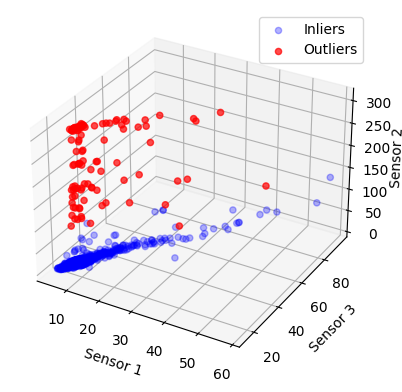

In [28]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(residual_threshold=70, random_state = 0)

features = ['bridge2','bridge3']
outputs = ['bridge5']

X = df[features]
y5 = df[outputs]
ransac.fit(X, y5)

inliers_mask5 = ransac.inlier_mask_
outliers_mask5 = np.logical_not(inliers_mask5)

fig = plt.figure(figsize =(6,6))
plt.subplots_adjust(bottom=0.2, left=0.1, right=0.9, top=0.8)
ax = fig.add_subplot(projection='3d')
ax.scatter(X['bridge2'][inliers_mask5], X['bridge3'][inliers_mask5], y5['bridge5'][inliers_mask5], c='blue', alpha=0.3,
            label='Inliers')
ax.scatter(X['bridge2'][outliers_mask5], X['bridge3'][outliers_mask5], y5['bridge5'][outliers_mask5], c='red', alpha=0.7,
            label='Outliers')
ax.legend(loc='best')
ax.set_xlabel('Sensor 1')
ax.set_ylabel('Sensor 3')
ax.set_zlabel('Sensor 2', labelpad=0.01)


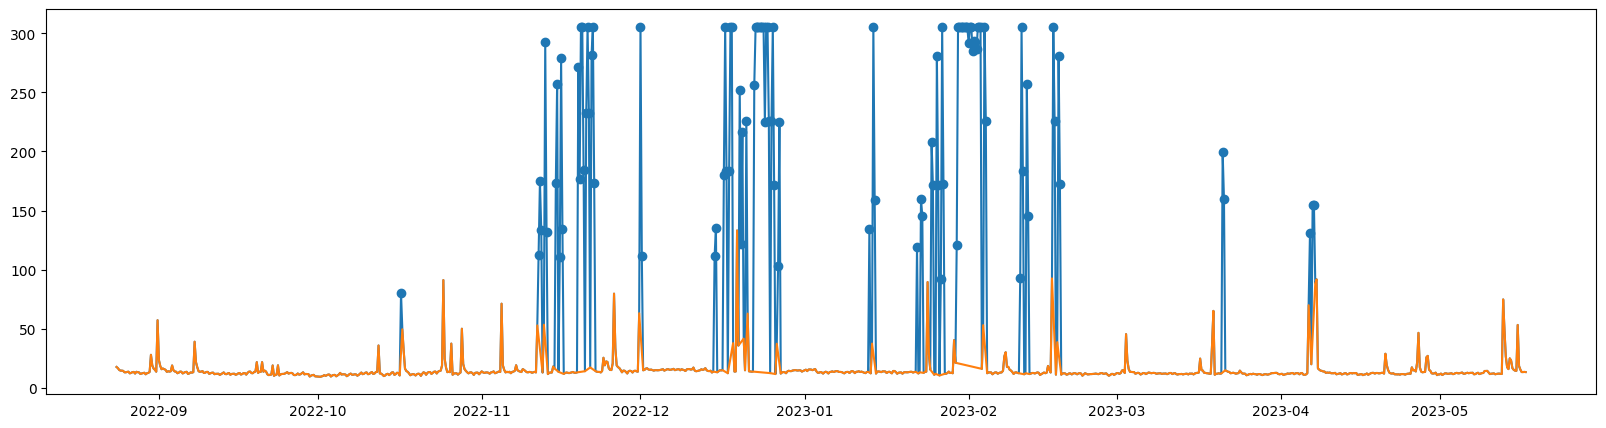

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

ax.plot(df['bridge5'])
ax.plot(y.index[inliers_mask5], y5['bridge5'][inliers_mask5])
ax.scatter(y.index[outliers_mask5], y5['bridge5'][outliers_mask5])

# ML regression 

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import xgboost

In [31]:
features = ['bridge2','bridge3']
outputs = ['bridge4','bridge5']

X = df[features]
y = df[outputs]

In [32]:
df1 = X['2022-08-24':'2022-09-15']
#df2 = X['2022-10-15':'2022-10-18']
df3 = X['2022-10-27':'2022-11-10']
df4 = X['2023-02-05':'2023-02-09']
df5 = X['2023-03-01 00:00:00':'2023-03-18 00:00:00']
X_train = pd.concat([df1, df3, df4, df5])

df6 = y['2022-08-24':'2022-09-15']
#df7 = y['2022-10-15':'2022-10-18']
df8 = y['2022-10-27':'2022-11-10']
df9 = y['2023-02-05':'2023-02-09']
df10 = y['2023-03-01 00:00:00':'2023-03-18 00:00:00']
y_train = pd.concat([df6, df8, df9, df10])

In [33]:
X_test = X['2023-04-12':'2023-05-15']
y_test = y['2023-04-12':'2023-05-15']

# Random Forest

In [34]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer
model = RandomForestRegressor()

# define the hyperparameter grid to search over
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    #'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000, 5000]
}
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='neg_mean_squared_error', n_jobs = -1)
grid_search.fit(X_train, y_train)

# print the best hyperparameters and corresponding mean squared error
print("Best hyperparameters:", grid_search.best_params_)
print("Best mean squared error:", -grid_search.best_score_)

Best hyperparameters: {'max_depth': 5, 'n_estimators': 100}
Best mean squared error: 2.7260481887173


In [35]:
regr = grid_search.best_estimator_
regr.fit(X_train, y_train)
y_pred_rf_train = regr.predict(X_train)
y_pred_rf_test = regr.predict(X_test)

In [36]:
y_pred_rf = regr.predict(X)

In [37]:
from sklearn.metrics import r2_score
y_true = y_test['bridge4']
y_pred = y_pred_rf_test[:,0]
r2 = r2_score(y_true, y_pred)
r2

0.9567372594947628

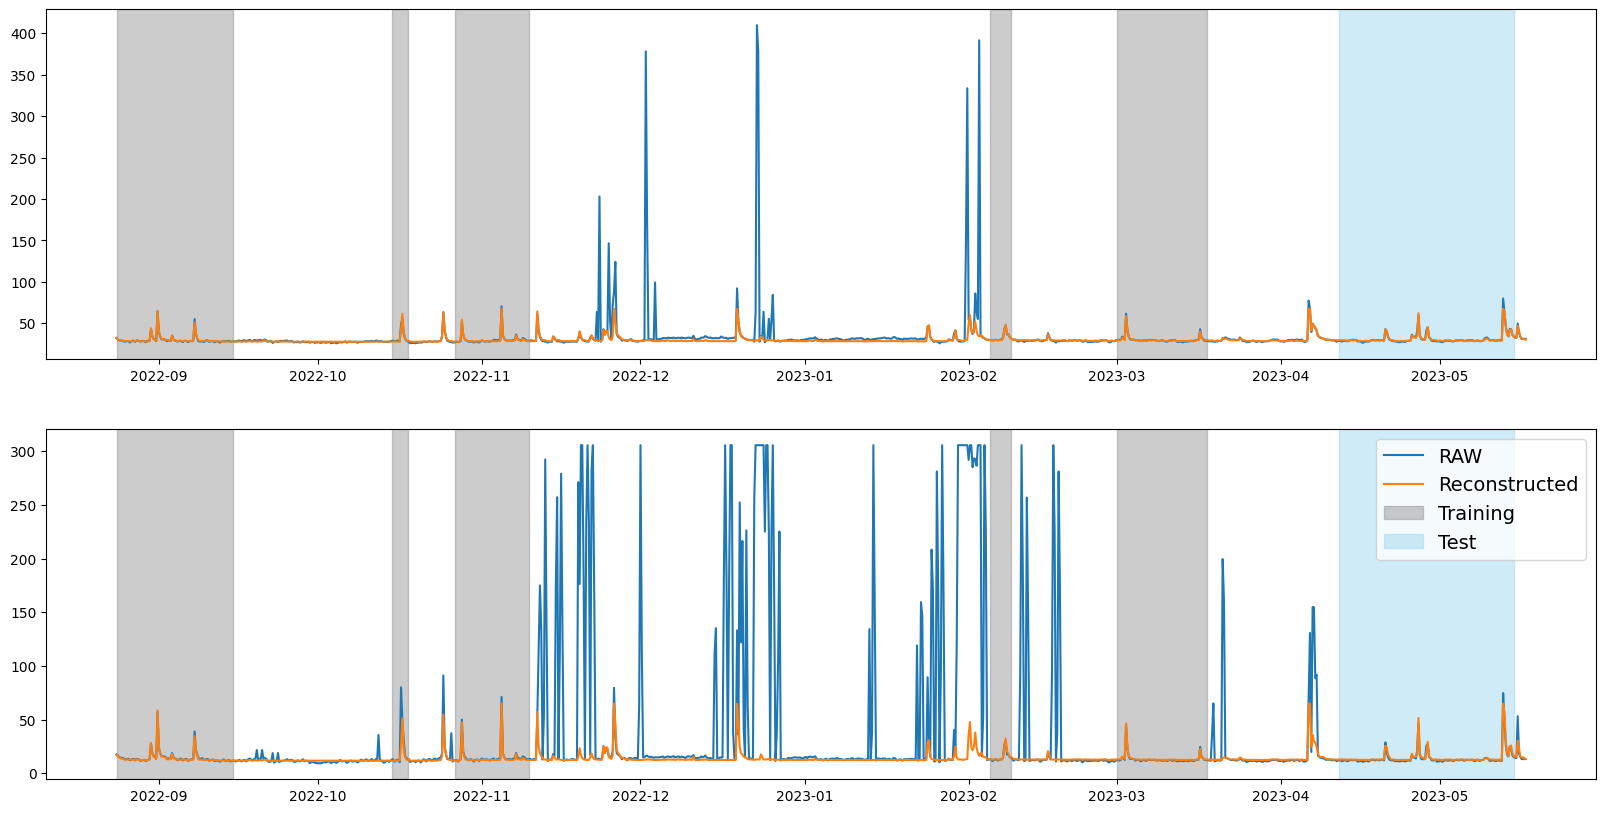

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

ax[0].plot(y.index, y['bridge4'], label = 'RAW')
ax[0].plot(y.index, y_pred_rf[:,0], label = 'Reconstructed')

ax[0].axvspan(xmin='2022-08-24', xmax='2022-09-15', color='gray', alpha=0.4, label='Training')
ax[0].axvspan(xmin='2022-10-15', xmax='2022-10-18', color='gray', alpha=0.4, label='Training')
ax[0].axvspan(xmin='2022-10-27', xmax='2022-11-10', color='gray', alpha=0.4, label='Training')
ax[0].axvspan(xmin='2023-02-05', xmax='2023-02-09', color='gray', alpha=0.4, label='Training')
ax[0].axvspan(xmin='2023-03-01 00:00:00', xmax='2023-03-18 00:00:00', color='gray', alpha=0.4, label='Training')

ax[0].axvspan(xmin='2023-04-12', xmax='2023-05-15', color='skyblue', alpha=0.4, label='Test')
#ax[0].set_ylim([0, 100])

ax[1].plot(y.index, y['bridge5'], label = 'RAW')
ax[1].plot(y.index, y_pred_rf[:,1], label = 'Reconstructed')
ax[1].axvspan(xmin='2022-08-24', xmax='2022-09-15', color='gray', alpha=0.4, label='')
ax[1].axvspan(xmin='2022-10-15', xmax='2022-10-18', color='gray', alpha=0.4, label='')
ax[1].axvspan(xmin='2022-10-27', xmax='2022-11-10', color='gray', alpha=0.4, label='')
ax[1].axvspan(xmin='2023-02-05', xmax='2023-02-09', color='gray', alpha=0.4, label='')
ax[1].axvspan(xmin='2023-03-01 00:00:00', xmax='2023-03-18 00:00:00', color='gray', alpha=0.4, label='Training')

ax[1].axvspan(xmin='2023-04-12', xmax='2023-05-15', color='skyblue', alpha=0.4, label='Test')
#ax[1].set_ylim([0, 100])
plt.legend(fontsize = 14)

# Multiple Linear Regression

In [39]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
# define the linear regression model
scaler = StandardScaler()
model = LinearRegression()
pipeline = Pipeline(steps=[('scaler', scaler), ('model', model)])

# set up the time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# define the hyperparameter grid to search over
param_grid = {
    'model__fit_intercept': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='neg_mean_squared_error', n_jobs = -1)

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best mean squared error:", -grid_search.best_score_)

Best hyperparameters: {'model__fit_intercept': True}
Best mean squared error: 4.258178997392593


In [40]:
scaler = StandardScaler()
model = LinearRegression(fit_intercept=True) # set best hyperparameters
pipeline = Pipeline(steps=[('scaler', scaler), ('model', model)])
pipeline.fit(X_train, y_train)
y_pred_lr_train = pipeline.predict(X_train)
y_pred_lr_test = pipeline.predict(X_test)

In [41]:
y_pred_lr = pipeline.predict(X)

In [42]:
from sklearn.metrics import r2_score
y_true = y_test['bridge4']
y_pred = y_pred_lr_test[:,0]
r2 = r2_score(y_true, y_pred)
r2

0.9473721806307556

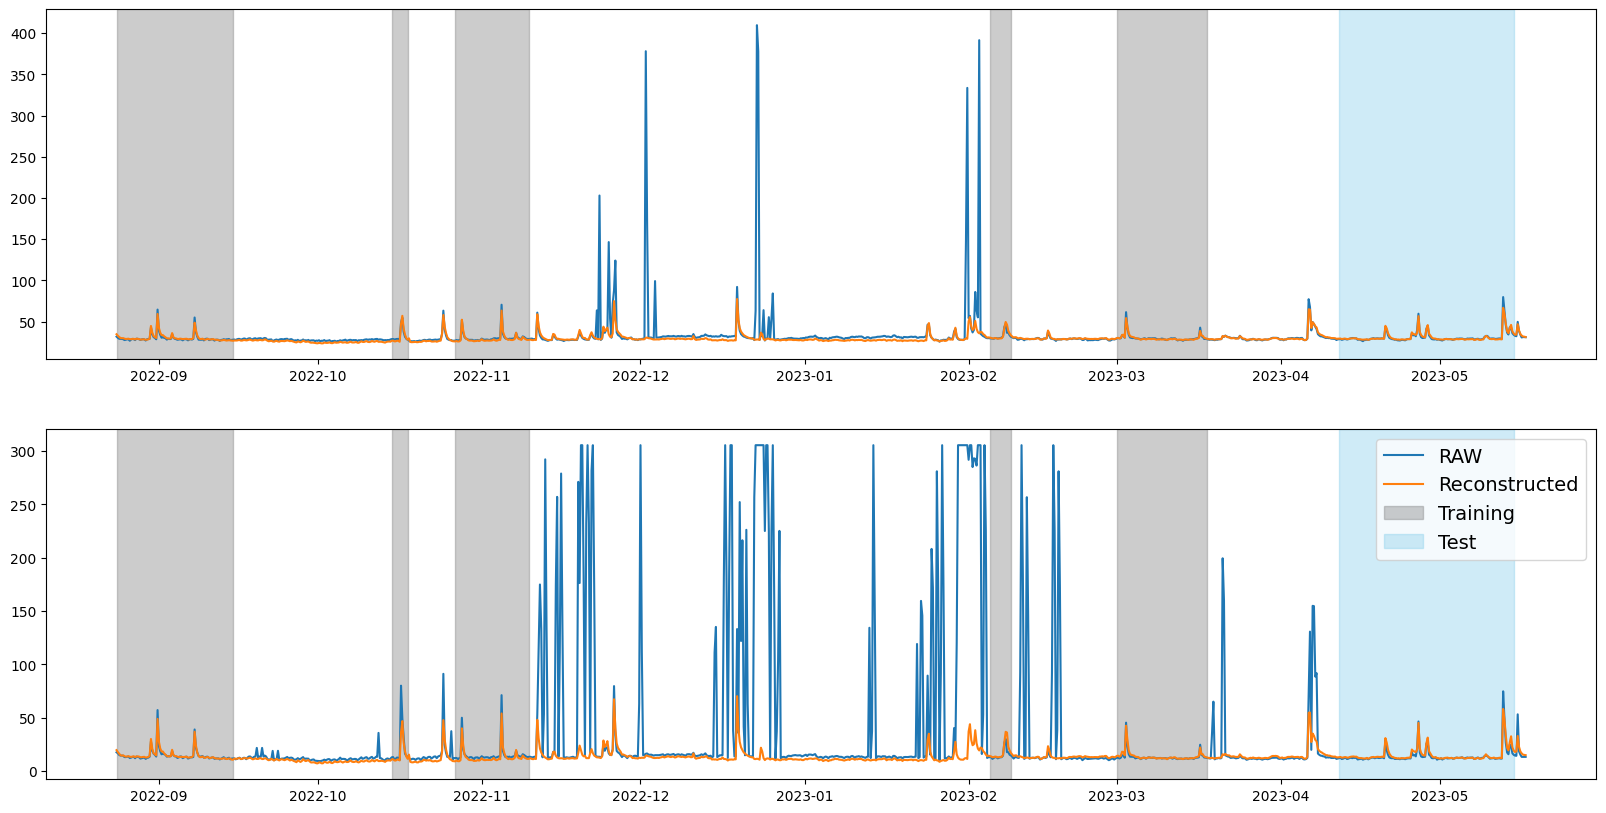

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

ax[0].plot(y.index, y['bridge4'], label = 'RAW')
ax[0].plot(y.index, y_pred_lr[:,0], label = 'Reconstructed')

ax[0].axvspan(xmin='2022-08-24', xmax='2022-09-15', color='gray', alpha=0.4, label='Training')
ax[0].axvspan(xmin='2022-10-15', xmax='2022-10-18', color='gray', alpha=0.4, label='Training')
ax[0].axvspan(xmin='2022-10-27', xmax='2022-11-10', color='gray', alpha=0.4, label='Training')
ax[0].axvspan(xmin='2023-02-05', xmax='2023-02-09', color='gray', alpha=0.4, label='Training')
ax[0].axvspan(xmin='2023-03-01 00:00:00', xmax='2023-03-18 00:00:00', color='gray', alpha=0.4, label='Training')

ax[0].axvspan(xmin='2023-04-12', xmax='2023-05-15', color='skyblue', alpha=0.4, label='Test')

ax[1].plot(y.index, y['bridge5'], label = 'RAW')
ax[1].plot(y.index, y_pred_lr[:,1], label = 'Reconstructed')
ax[1].axvspan(xmin='2022-08-24', xmax='2022-09-15', color='gray', alpha=0.4, label='')
ax[1].axvspan(xmin='2022-10-15', xmax='2022-10-18', color='gray', alpha=0.4, label='')
ax[1].axvspan(xmin='2022-10-27', xmax='2022-11-10', color='gray', alpha=0.4, label='')
ax[1].axvspan(xmin='2023-02-05', xmax='2023-02-09', color='gray', alpha=0.4, label='')
ax[1].axvspan(xmin='2023-03-01 00:00:00', xmax='2023-03-18 00:00:00', color='gray', alpha=0.4, label='Training')

ax[1].axvspan(xmin='2023-04-12', xmax='2023-05-15', color='skyblue', alpha=0.4, label='Test')
#ax[1].set_ylim([0, 100])
plt.legend(fontsize = 14)

# K-nearest neighbors

In [44]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()

tscv = TimeSeriesSplit(n_splits=5)

# Define a range of hyperparameters to search over
param_grid = {'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10], 'weights': ['uniform', 'distance']}

grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='neg_mean_squared_error', n_jobs = -1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best mean squared error:", -grid_search.best_score_)

Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance'}
Best mean squared error: 3.504708243420849


In [45]:
best_knn = grid_search.best_estimator_
best_knn.fit(X_train, y_train)
y_pred_knn_train = best_knn.predict(X_train)
y_pred_knn_test = best_knn.predict(X_test)

In [46]:
y_pred_knn = best_knn.predict(X)

In [47]:
from sklearn.metrics import r2_score
y_true = y_test['bridge4']
y_pred = y_pred_knn_test[:,0]
r2 = r2_score(y_true, y_pred)
r2

0.9494822230776252

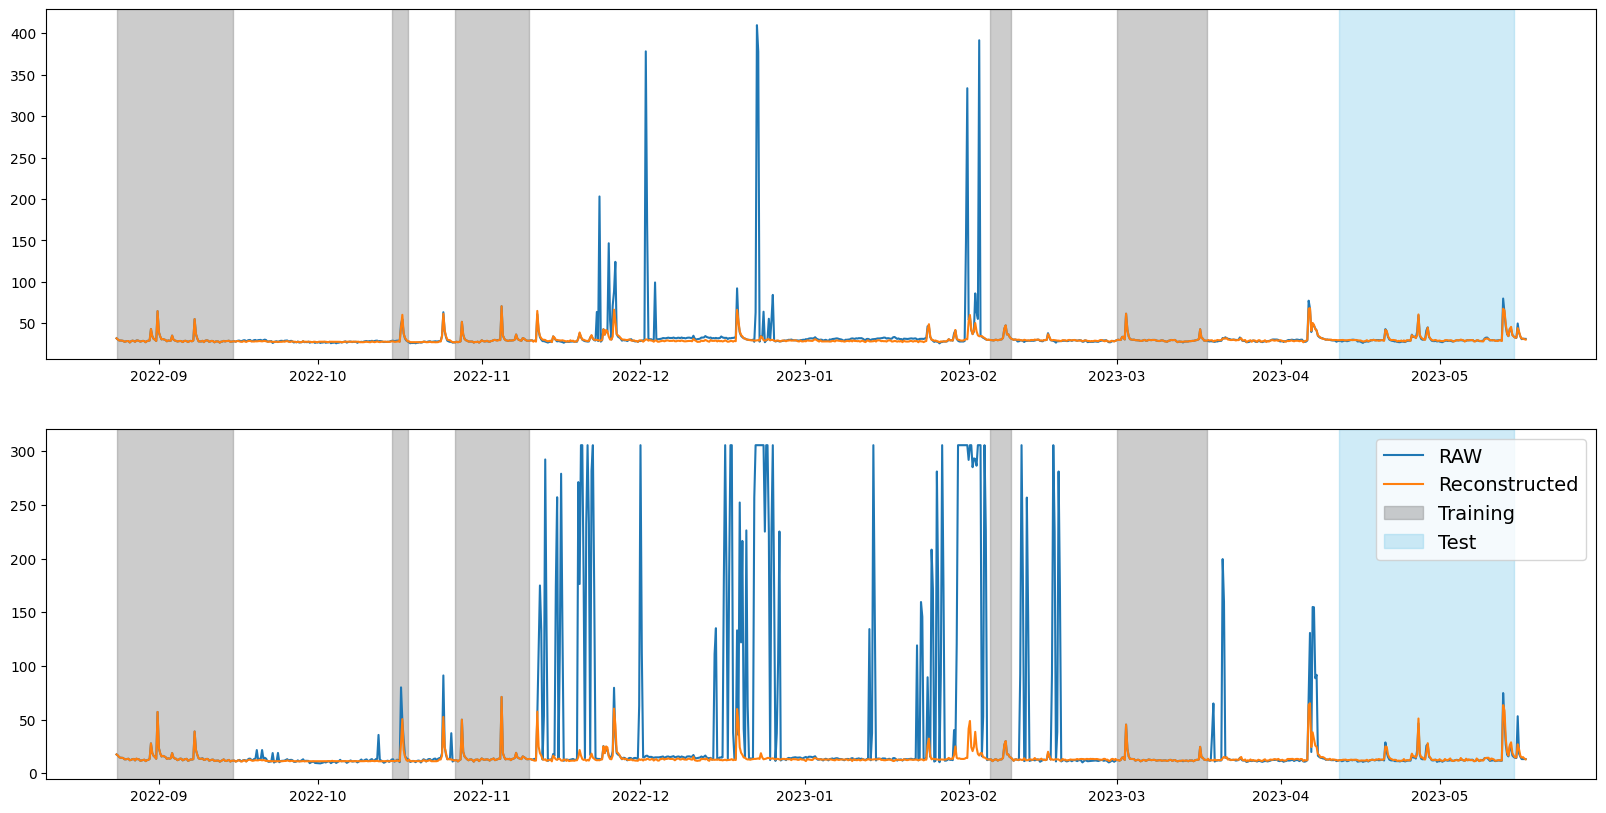

In [48]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

ax[0].plot(y.index, y['bridge4'], label = 'RAW')
ax[0].plot(y.index, y_pred_knn[:,0], label = 'Reconstructed')

ax[0].axvspan(xmin='2022-08-24', xmax='2022-09-15', color='gray', alpha=0.4, label='Training')
ax[0].axvspan(xmin='2022-10-15', xmax='2022-10-18', color='gray', alpha=0.4, label='Training')
ax[0].axvspan(xmin='2022-10-27', xmax='2022-11-10', color='gray', alpha=0.4, label='Training')
ax[0].axvspan(xmin='2023-02-05', xmax='2023-02-09', color='gray', alpha=0.4, label='Training')
ax[0].axvspan(xmin='2023-03-01 00:00:00', xmax='2023-03-18 00:00:00', color='gray', alpha=0.4, label='Training')

ax[0].axvspan(xmin='2023-04-12', xmax='2023-05-15', color='skyblue', alpha=0.4, label='Test')

ax[1].plot(y.index, y['bridge5'], label = 'RAW')
ax[1].plot(y.index, y_pred_knn[:,1], label = 'Reconstructed')
ax[1].axvspan(xmin='2022-08-24', xmax='2022-09-15', color='gray', alpha=0.4, label='')
ax[1].axvspan(xmin='2022-10-15', xmax='2022-10-18', color='gray', alpha=0.4, label='')
ax[1].axvspan(xmin='2022-10-27', xmax='2022-11-10', color='gray', alpha=0.4, label='')
ax[1].axvspan(xmin='2023-02-05', xmax='2023-02-09', color='gray', alpha=0.4, label='')
ax[1].axvspan(xmin='2023-03-01 00:00:00', xmax='2023-03-18 00:00:00', color='gray', alpha=0.4, label='Training')

ax[1].axvspan(xmin='2023-04-12', xmax='2023-05-15', color='skyblue', alpha=0.4, label='Test')
#ax[1].set_ylim([0, 100])
plt.legend(fontsize = 14)

# SVR

In [49]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
# Create an SVR object
svr = SVR()
multi_svr = MultiOutputRegressor(svr)

# Define a grid of hyperparameters to search
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10, 100],
    'estimator__kernel': ['linear', 'rbf', 'sigmoid'],
    'estimator__gamma': [0.1, 1, 10, 'scale', 'auto'],
    'estimator__epsilon': [0.1, 0.2, 0.3, 0.4, 0.5]
}

# Create a GridSearchCV object
grid = GridSearchCV(multi_svr, param_grid=param_grid, cv = kfold, scoring='neg_mean_squared_error', n_jobs = -1)

# Fit the model to the data
grid.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding score
best_params = grid.best_params_
best_score = grid.best_score_

# Print the results
print("Best hyperparameters: ", best_params)
print("Best score: ", best_score)

Best hyperparameters:  {'estimator__C': 100, 'estimator__epsilon': 0.4, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}
Best score:  -4.597941295703647


In [50]:
best_svr = grid.best_estimator_
best_svr.fit(X_train, y_train)
y_pred_svr_train = best_svr.predict(X_train)
y_pred_svr_test = best_svr.predict(X_test)

In [51]:
y_pred_svr = best_svr.predict(X)

In [52]:
from sklearn.metrics import r2_score
y_true = y_test['bridge4']
y_pred = y_pred_svr_test[:,0]
r2 = r2_score(y_true, y_pred)
r2

0.9562831071430381

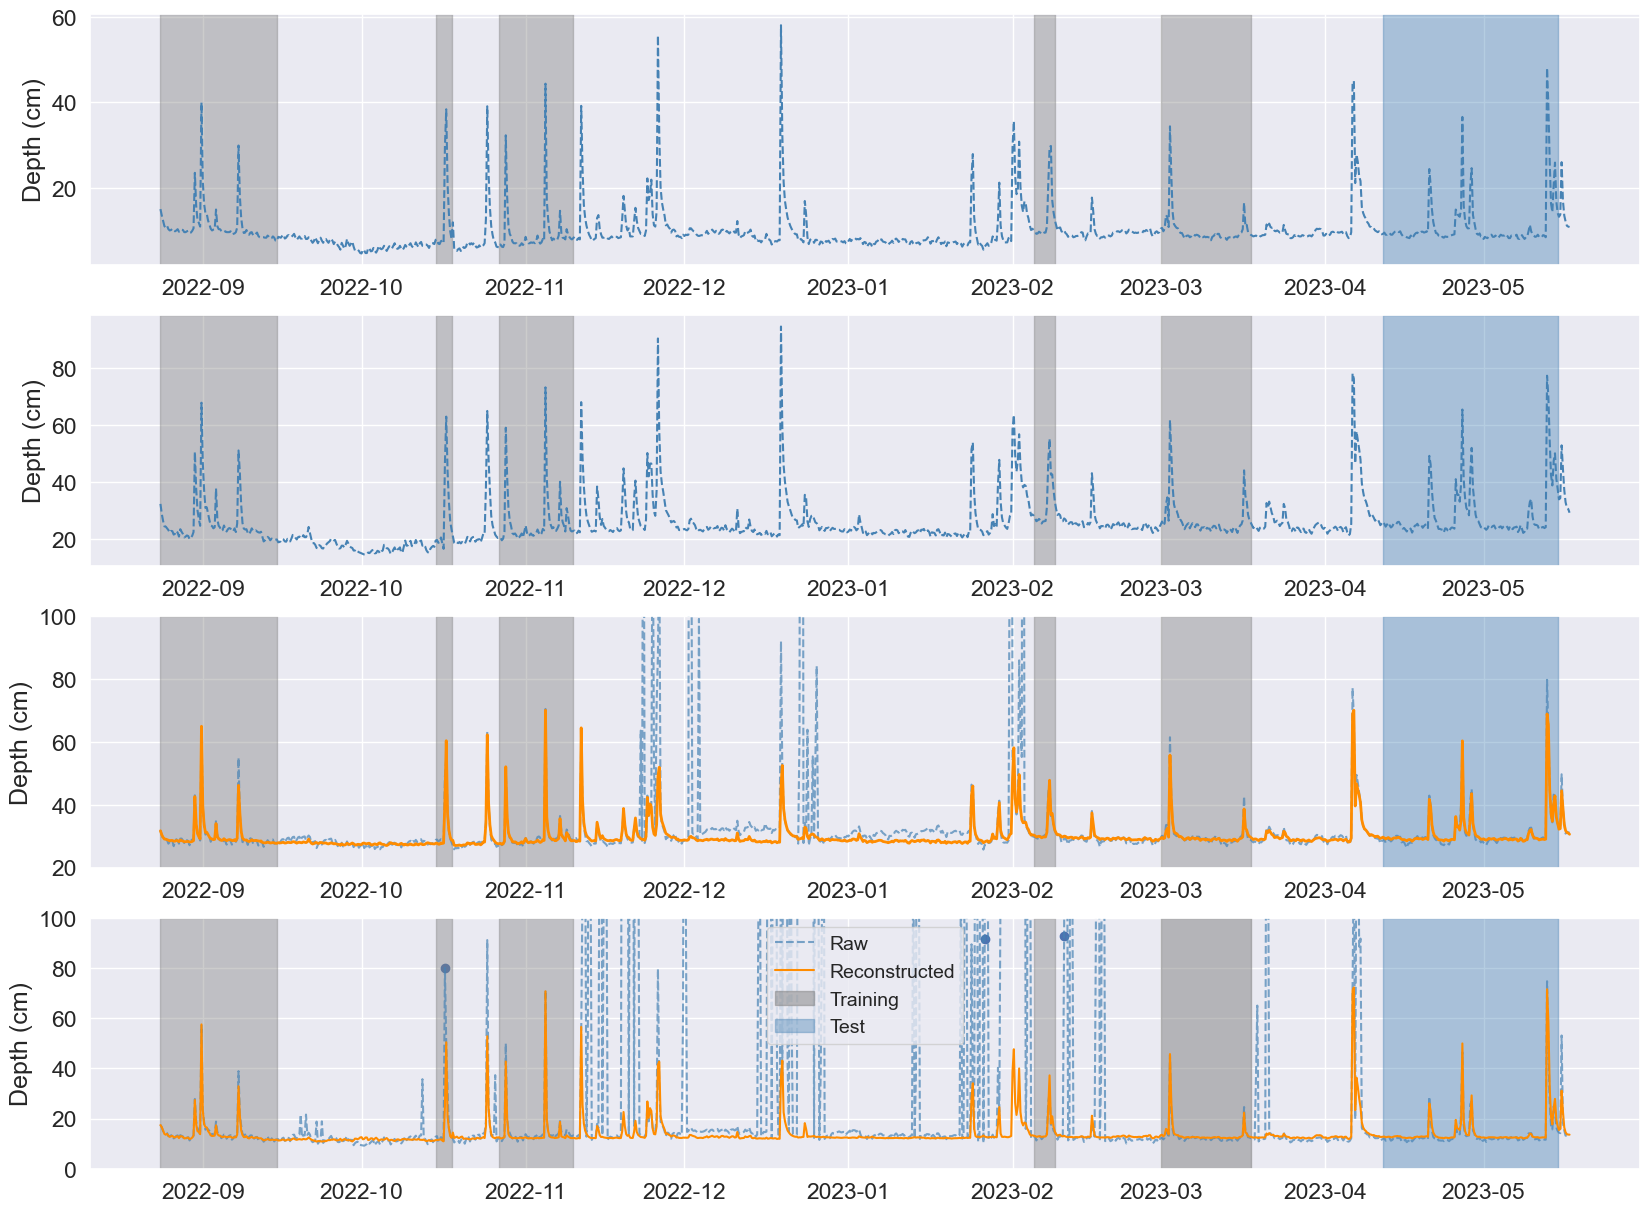

In [53]:
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('darkgrid')
fig, ax = plt.subplots(4, 1, figsize=(20, 15))

ax[0].plot(X.index, X['bridge2'], '--', color='steelblue', label = 'Raw')
ax[0].axvspan(xmin='2022-08-24', xmax='2022-09-15', color='grey', alpha=0.4, label='Train')
ax[0].axvspan(xmin='2022-10-15', xmax='2022-10-18', color='grey', alpha=0.4, label='Train')
ax[0].axvspan(xmin='2022-10-27', xmax='2022-11-10', color='grey', alpha=0.4, label='Train')
ax[0].axvspan(xmin='2023-02-05', xmax='2023-02-09', color='grey', alpha=0.4, label='Train')
ax[0].axvspan(xmin='2023-03-01 00:00:00', xmax='2023-03-18 00:00:00', color='grey', alpha=0.4, label='Train')
ax[0].set_ylabel('Depth (cm)')
ax[0].axvspan(xmin='2023-04-12', xmax='2023-05-15', color='steelblue', alpha=0.4, label='Test')

ax[1].plot(X.index, X['bridge3'], '--', color='steelblue', label = 'Raw')
ax[1].axvspan(xmin='2022-08-24', xmax='2022-09-15', color='grey', alpha=0.4, label='Train')
ax[1].axvspan(xmin='2022-10-15', xmax='2022-10-18', color='grey', alpha=0.4, label='Train')
ax[1].axvspan(xmin='2022-10-27', xmax='2022-11-10', color='grey', alpha=0.4, label='Train')
ax[1].axvspan(xmin='2023-02-05', xmax='2023-02-09', color='grey', alpha=0.4, label='Train')
ax[1].axvspan(xmin='2023-03-01 00:00:00', xmax='2023-03-18 00:00:00', color='grey', alpha=0.4, label='Train')
ax[1].set_ylabel('Depth (cm)')
ax[1].axvspan(xmin='2023-04-12', xmax='2023-05-15', color='steelblue', alpha=0.4, label='Test')

ax[2].plot(y.index, y['bridge4'], '--', color='steelblue', alpha=0.7, label = 'Raw')
ax[2].plot(y.index, y_pred_svr[:,0], color='darkorange',label = 'Reconstructed', lw=2)
ax[3].scatter(y.index[outliers_mask5], y5['bridge5'][outliers_mask5])
ax[2].axvspan(xmin='2022-08-24', xmax='2022-09-15', color='grey', alpha=0.4, label='Train')
ax[2].axvspan(xmin='2022-10-15', xmax='2022-10-18', color='grey', alpha=0.4, label='Train')
ax[2].axvspan(xmin='2022-10-27', xmax='2022-11-10', color='grey', alpha=0.4, label='Train')
ax[2].axvspan(xmin='2023-02-05', xmax='2023-02-09', color='grey', alpha=0.4, label='Train')
ax[2].axvspan(xmin='2023-03-01 00:00:00', xmax='2023-03-18 00:00:00', color='grey', alpha=0.4, label='Train')
ax[2].set_ylabel('Depth (cm)')
ax[2].axvspan(xmin='2023-04-12', xmax='2023-05-15', color='steelblue', alpha=0.4, label='Test')
ax[2].set_ylim([20, 100])

ax[3].plot(y.index, y['bridge5'], '--', color='steelblue', alpha=0.7, label = 'Raw')
ax[3].plot(y.index, y_pred_svr[:,1], color='darkorange', label = 'Reconstructed', lw=1.5)
ax[3].axvspan(xmin='2022-08-24', xmax='2022-09-15', color='grey', alpha=0.4, label='')
ax[3].axvspan(xmin='2022-10-15', xmax='2022-10-18', color='grey', alpha=0.4, label='')
ax[3].axvspan(xmin='2022-10-27', xmax='2022-11-10', color='grey', alpha=0.4, label='')
ax[3].axvspan(xmin='2023-02-05', xmax='2023-02-09', color='grey', alpha=0.4, label='')
ax[3].axvspan(xmin='2023-03-01 00:00:00', xmax='2023-03-18 00:00:00', color='grey', alpha=0.5, label='Training')
ax[3].set_ylabel('Depth (cm)')
ax[3].axvspan(xmin='2023-04-12', xmax='2023-05-15', color='steelblue', alpha=0.4, label='Test')
ax[3].set_ylim([0, 100])
plt.legend(fontsize = 14)

# Evaluation

In [54]:
from sklearn.metrics import r2_score
import seaborn as sns
from scipy.stats import gaussian_kde

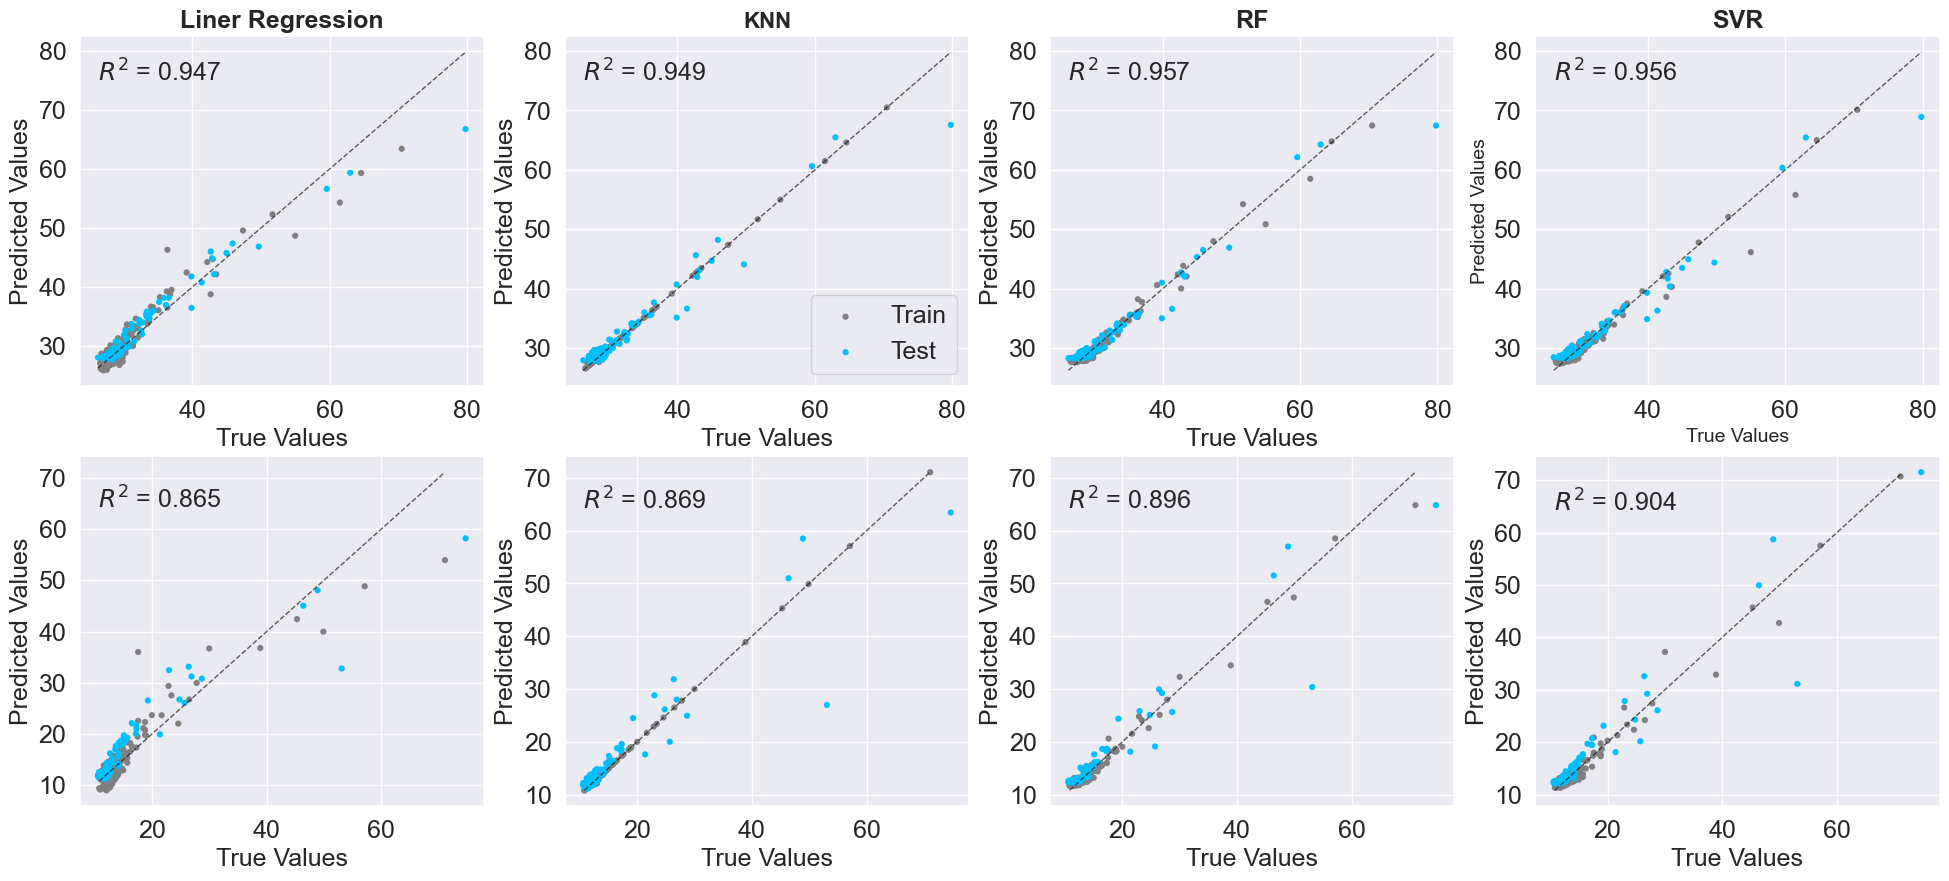

In [55]:
sns.set(font_scale=1.5)
sns.set_style("darkgrid")

fig, ax = plt.subplots(2, 4, figsize=(24, 10))

y_true = y_test['bridge4']
y_pred = y_pred_lr_test[:,0]
r2 = r2_score(y_true, y_pred)
ax[0,0].scatter(y_train['bridge4'], y_pred_lr_train[:,0], s=20, edgecolors='none', c='grey')
ax[0,0].scatter(y_true, y_pred, s=20, edgecolors='none', c='deepskyblue')
ax[0,0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=1, alpha = 0.7)
ax[0,0].set_xlabel('True Values', fontsize=18)
ax[0,0].set_ylabel('Predicted Values', fontsize=18)
ax[0,0].text(y_true.min(), y_true.max() - 5,'\n$R^2$ = {:.3f}'.format(r2), fontsize=18)
ax[0,0].tick_params(axis='both', labelsize=18)
ax[0,0].set_title('Liner Regression', fontsize=18, fontweight="bold")

y_pred = y_pred_knn_test[:,0]
r2 = r2_score(y_true, y_pred)
ax[0,1].scatter(y_train['bridge4'], y_pred_knn_train[:,0], s=20, edgecolors='none', c='grey', label = 'Train')
ax[0,1].scatter(y_true, y_pred, s=20, edgecolors='none', c='deepskyblue', label = 'Test')
ax[0,1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=1, alpha = 0.7)
ax[0,1].set_xlabel('True Values', fontsize=18)
ax[0,1].set_ylabel('Predicted Values', fontsize=18)
ax[0,1].text(y_true.min(), y_true.max() - 5,'\n$R^2$ = {:.3f}'.format(r2), fontsize=18)
ax[0,1].tick_params(axis='both', labelsize=18)
ax[0,1].set_title('KNN', fontsize=16, fontweight="bold")
ax[0,1].legend(loc = 'lower right',  fontsize=18)

y_pred = y_pred_rf_test[:,0]
r2 = r2_score(y_true, y_pred)
ax[0,2].scatter(y_train['bridge4'], y_pred_rf_train[:,0], s=20, edgecolors='none', c='grey', label = 'Train')
ax[0,2].scatter(y_true, y_pred, s=20, edgecolors='none', c='deepskyblue', label = 'Test')
ax[0,2].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=1, alpha = 0.7)
ax[0,2].set_xlabel('True Values', fontsize=18)
ax[0,2].set_ylabel('Predicted Values', fontsize=18)
ax[0,2].text(y_true.min(), y_true.max() - 5,'\n$R^2$ = {:.3f}'.format(r2), fontsize=18)
ax[0,2].tick_params(axis='both', labelsize=18)
ax[0,2].set_title('RF', fontsize=18, fontweight="bold")

y_pred = y_pred_svr_test[:,0]
r2 = r2_score(y_true, y_pred)
ax[0,3].scatter(y_train['bridge4'], y_pred_svr_train[:,0], s=20, edgecolors='none', c='grey')
ax[0,3].scatter(y_true, y_pred, s=20, edgecolors='none', c='deepskyblue')
ax[0,3].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=1, alpha = 0.7)
ax[0,3].set_xlabel('True Values', fontsize=14)
ax[0,3].set_ylabel('Predicted Values', fontsize=14)
ax[0,3].text(y_true.min(), y_true.max() - 5,'\n$R^2$ = {:.3f}'.format(r2), fontsize=18)
ax[0,3].tick_params(axis='both', labelsize=18)
ax[0,3].set_title('SVR', fontsize=18, fontweight='bold')

y_true = y_test['bridge5']
y_pred = y_pred_lr_test[:,1]
r2 = r2_score(y_true, y_pred)
ax[1,0].scatter(y_train['bridge5'], y_pred_lr_train[:,1], s=20, edgecolors='none', c='grey')
ax[1,0].scatter(y_true, y_pred, s=20, edgecolors='none', c='deepskyblue')
ax[1,0].plot([y_train['bridge5'].min(), y_train['bridge5'].max()], [y_train['bridge5'].min(), y_train['bridge5'].max()], 'k--', lw=1, alpha = 0.7)
ax[1,0].set_xlabel('True Values', fontsize=18)
ax[1,0].set_ylabel('Predicted Values', fontsize=18)
ax[1,0].text(y_true.min(), y_train['bridge5'].max() - 7,'\n$R^2$ = {:.3f}'.format(r2), fontsize=18)
ax[1,0].tick_params(axis='both', labelsize=18)

y_pred = y_pred_knn_test[:,1]
r2 = r2_score(y_true, y_pred)
ax[1,1].scatter(y_train['bridge5'], y_pred_knn_train[:,1], s=20, edgecolors='none', c='grey')
ax[1,1].scatter(y_true, y_pred, s=20, edgecolors='none', c='deepskyblue')
ax[1,1].plot([y_train['bridge5'].min(), y_train['bridge5'].max()], [y_train['bridge5'].min(), y_train['bridge5'].max()], 'k--', lw=1, alpha = 0.7)
ax[1,1].set_xlabel('True Values', fontsize=18)
ax[1,1].set_ylabel('Predicted Values', fontsize=18)
ax[1,1].text(y_true.min(), y_train['bridge5'].max() - 7,'\n$R^2$ = {:.3f}'.format(r2), fontsize=18)
ax[1,1].tick_params(axis='both', labelsize=18)

y_pred = y_pred_rf_test[:,1]
r2 = r2_score(y_true, y_pred)
ax[1,2].scatter(y_train['bridge5'], y_pred_rf_train[:,1], s=20, edgecolors='none', c='grey')
ax[1,2].scatter(y_true, y_pred, s=20, edgecolors='none', c='deepskyblue')
ax[1,2].plot([y_train['bridge5'].min(), y_train['bridge5'].max()], [y_train['bridge5'].min(), y_train['bridge5'].max()], 'k--', lw=1, alpha = 0.7)
ax[1,2].set_xlabel('True Values', fontsize=18)
ax[1,2].set_ylabel('Predicted Values', fontsize=18)
ax[1,2].text(y_true.min(), y_train['bridge5'].max() - 7, "\n$R^2$ = {:.3f}".format(r2), fontsize=18)
ax[1,2].tick_params(axis='both', labelsize=18)

y_pred = y_pred_svr_test[:,1]
r2 = r2_score(y_true, y_pred)
ax[1,3].scatter(y_train['bridge5'], y_pred_svr_train[:,1], s=20, edgecolors='none', c='grey')
ax[1,3].scatter(y_true, y_pred, s=20, edgecolors='none', c='deepskyblue')
ax[1,3].plot([y_train['bridge5'].min(), y_train['bridge5'].max()], [y_train['bridge5'].min(), y_train['bridge5'].max()], 'k--', lw=1, alpha = 0.7)
ax[1,3].set_xlabel('True Values', fontsize=18)
ax[1,3].set_ylabel('Predicted Values', fontsize=18)
ax[1,3].text(y_true.min(), y_train['bridge5'].max() - 7,'\n$R^2$ = {:.3f}'.format(r2), fontsize=18)
ax[1,3].tick_params(axis='both', labelsize=18)

plt.show()

## Ensembles

In [56]:
ensemble_predictions = np.mean([y_pred_lr, y_pred_knn, y_pred_rf, y_pred_svr], axis=0)
std_predictions = np.std([y_pred_lr, y_pred_knn, y_pred_rf, y_pred_svr], axis=0)

lower_bound = ensemble_predictions - 1.96 * std_predictions
upper_bound = ensemble_predictions + 1.96 * std_predictions

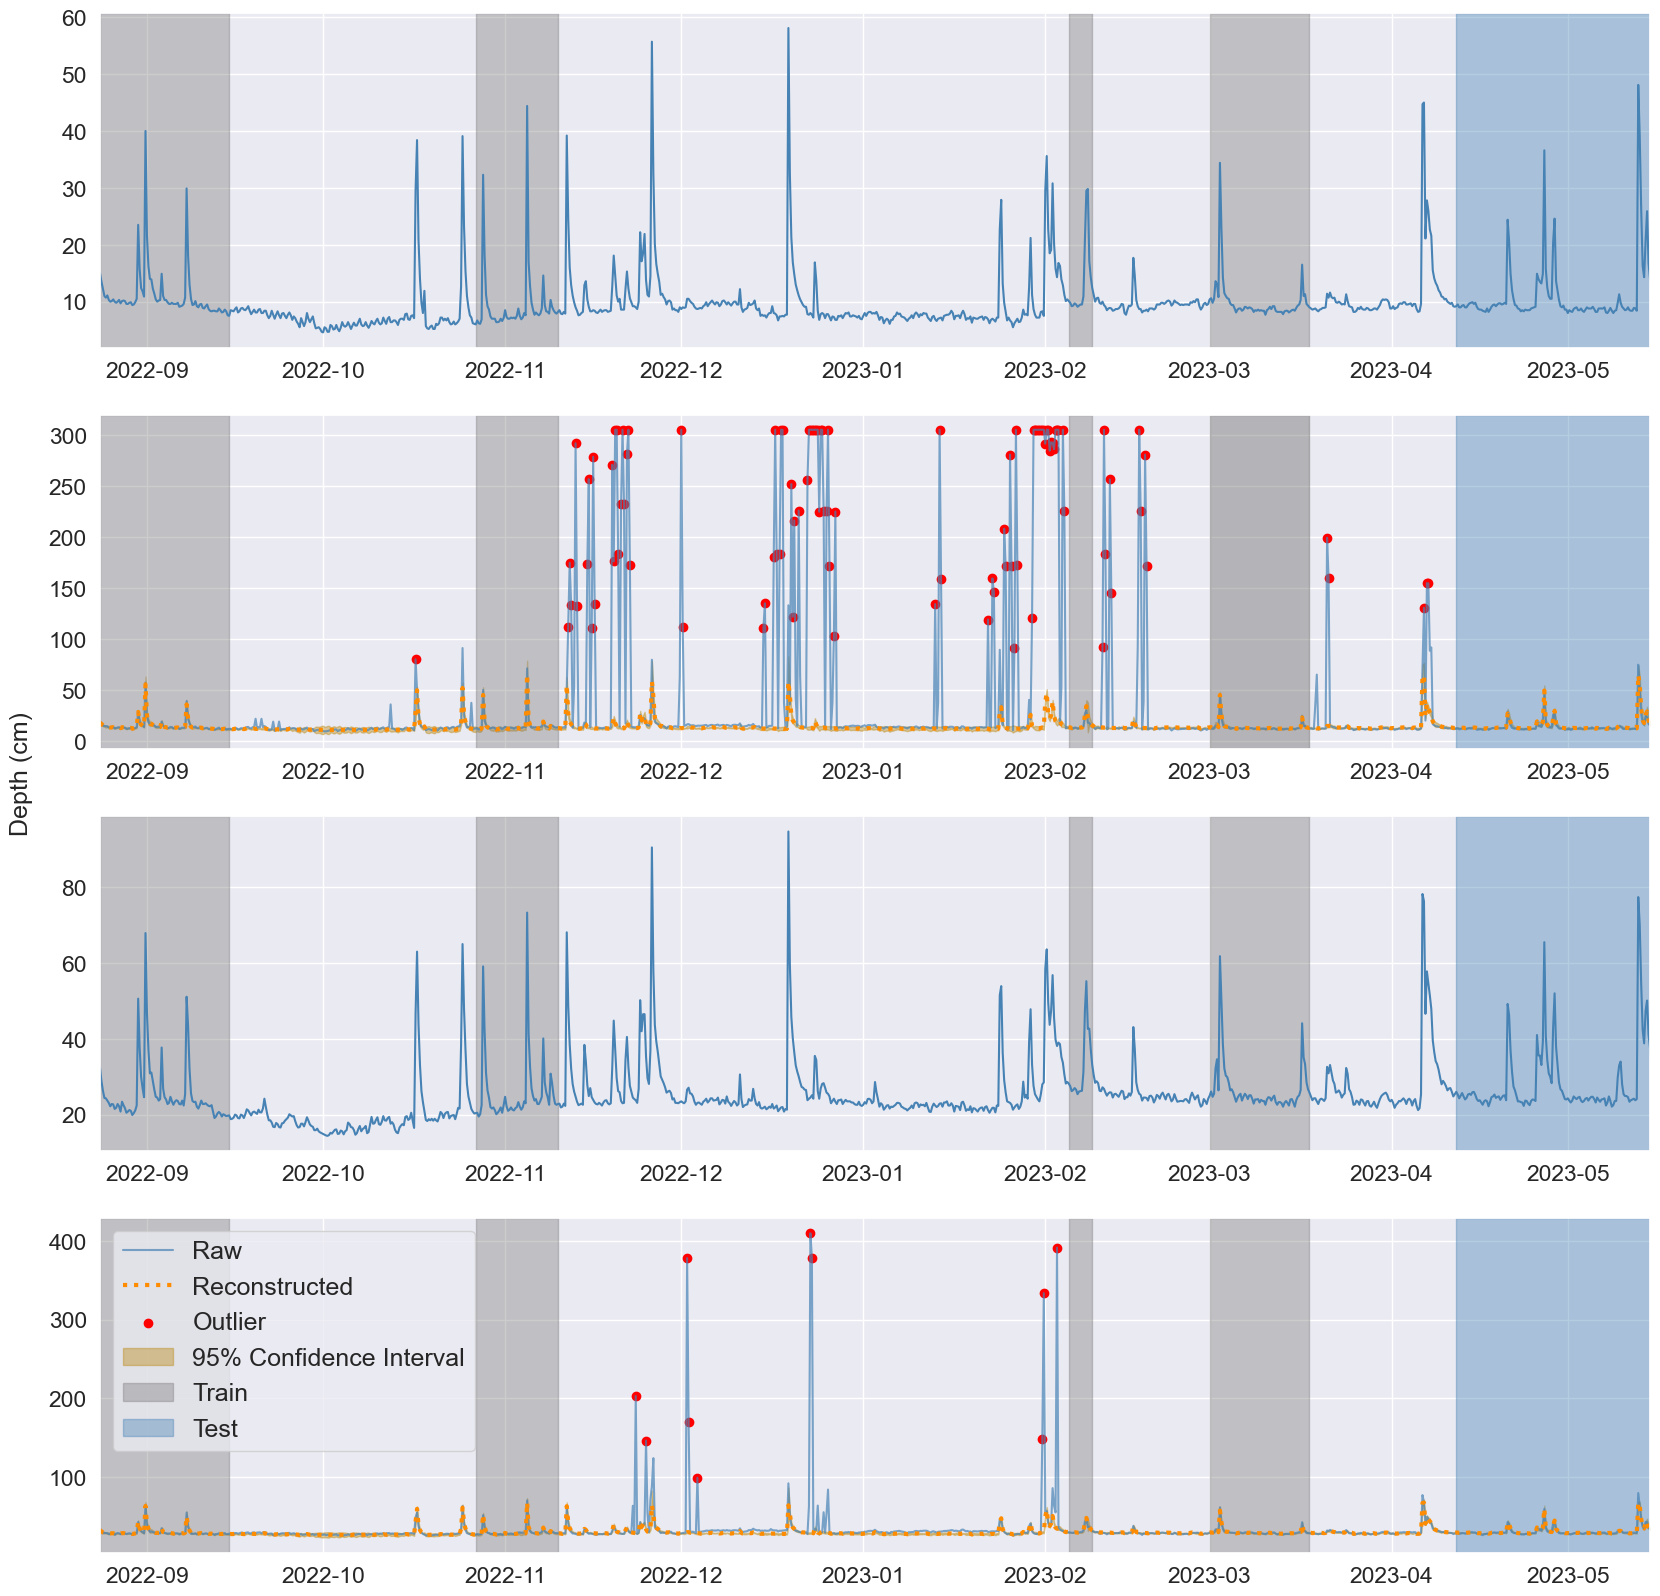

In [57]:
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('darkgrid')
fig, ax = plt.subplots(4, 1, figsize=(20, 20))

ax[0].plot(X.index, X['bridge2'], color='steelblue', label = 'Raw')
ax[0].axvspan(xmin='2022-08-24', xmax='2022-09-15', color='grey', alpha=0.4, label='Train')
ax[0].axvspan(xmin='2022-10-27', xmax='2022-11-10', color='grey', alpha=0.4, label='Train')
ax[0].axvspan(xmin='2023-02-05', xmax='2023-02-09', color='grey', alpha=0.4, label='Train')
ax[0].axvspan(xmin='2023-03-01 00:00:00', xmax='2023-03-18 00:00:00', color='grey', alpha=0.4, label='Train')
ax[0].axvspan(xmin='2023-04-12', xmax='2023-05-15', color='steelblue', alpha=0.4, label='Test')

ax[2].plot(X.index, X['bridge3'], color='steelblue', label = 'Raw')
ax[2].axvspan(xmin='2022-08-24', xmax='2022-09-15', color='grey', alpha=0.4, label='Train')
ax[2].axvspan(xmin='2022-10-27', xmax='2022-11-10', color='grey', alpha=0.4, label='Train')
ax[2].axvspan(xmin='2023-02-05', xmax='2023-02-09', color='grey', alpha=0.4, label='Train')
ax[2].axvspan(xmin='2023-03-01 00:00:00', xmax='2023-03-18 00:00:00', color='grey', alpha=0.4, label='Train')
ax[2].axvspan(xmin='2023-04-12', xmax='2023-05-15', color='steelblue', alpha=0.4, label='Test')

ax[3].plot(y.index, y['bridge4'], color='steelblue', alpha=0.7, label = 'Raw')
ax[3].plot(y.index, ensemble_predictions[:,0], ':', color='darkorange',label = 'Reconstructed', lw=3)
ax[3].scatter(y.index[outliers_mask4], y4['bridge4'][outliers_mask4], color='red', label = 'Outlier')
ax[3].fill_between(y.index, lower_bound[:,0], upper_bound[:,0], alpha=0.4, color = 'darkgoldenrod', label='95% Confidence Interval')
ax[3].axvspan(xmin='2022-08-24', xmax='2022-09-15', color='grey', alpha=0.4, label='')
ax[3].axvspan(xmin='2022-10-27', xmax='2022-11-10', color='grey', alpha=0.4, label='')
ax[3].axvspan(xmin='2023-02-05', xmax='2023-02-09', color='grey', alpha=0.4, label='')
ax[3].axvspan(xmin='2023-03-01 00:00:00', xmax='2023-03-18 00:00:00', color='grey', alpha=0.4, label='Train')
ax[3].axvspan(xmin='2023-04-12', xmax='2023-05-15', color='steelblue', alpha=0.4, label='Test')
#ax[2].set_ylim([20, 100])

ax[1].plot(y.index, y['bridge5'], color='steelblue', alpha=0.7, label = 'Raw')
ax[1].plot(y.index, ensemble_predictions[:,1], ':', color='darkorange', label = 'Reconstructed (Ensemble)', lw =3)
ax[1].scatter(y.index[outliers_mask5], y5['bridge5'][outliers_mask5], color='red', label = 'Outlier')
ax[1].fill_between(y.index, lower_bound[:,1], upper_bound[:,1], alpha=0.4, color = 'darkgoldenrod', label='95% Confidence Interval')
ax[1].axvspan(xmin='2022-08-24', xmax='2022-09-15', color='grey', alpha=0.4, label='')
ax[1].axvspan(xmin='2022-10-27', xmax='2022-11-10', color='grey', alpha=0.4, label='')
ax[1].axvspan(xmin='2023-02-05', xmax='2023-02-09', color='grey', alpha=0.4, label='')
ax[1].axvspan(xmin='2023-03-01 00:00:00', xmax='2023-03-18 00:00:00', color='grey', alpha=0.5, label='Train')
ax[1].axvspan(xmin='2023-04-12', xmax='2023-05-15', color='steelblue', alpha=0.4, label='Test')
#ax[3].set_ylim([0, 80])

ax[0].set_xlim([pd.to_datetime('2022-08-24'), pd.to_datetime('2023-05-15')])
ax[1].set_xlim([pd.to_datetime('2022-08-24'), pd.to_datetime('2023-05-15')])
ax[2].set_xlim([pd.to_datetime('2022-08-24'), pd.to_datetime('2023-05-15')])
ax[3].set_xlim([pd.to_datetime('2022-08-24'), pd.to_datetime('2023-05-15')])

# Set common labels
fig.text(0.08, 0.5, 'Depth (cm)', va='center', rotation='vertical')
ax[3].legend(fontsize = 18)
# Adjusting the legend's position
#handles, labels = ax[1].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.93), ncol=6, fontsize=18)


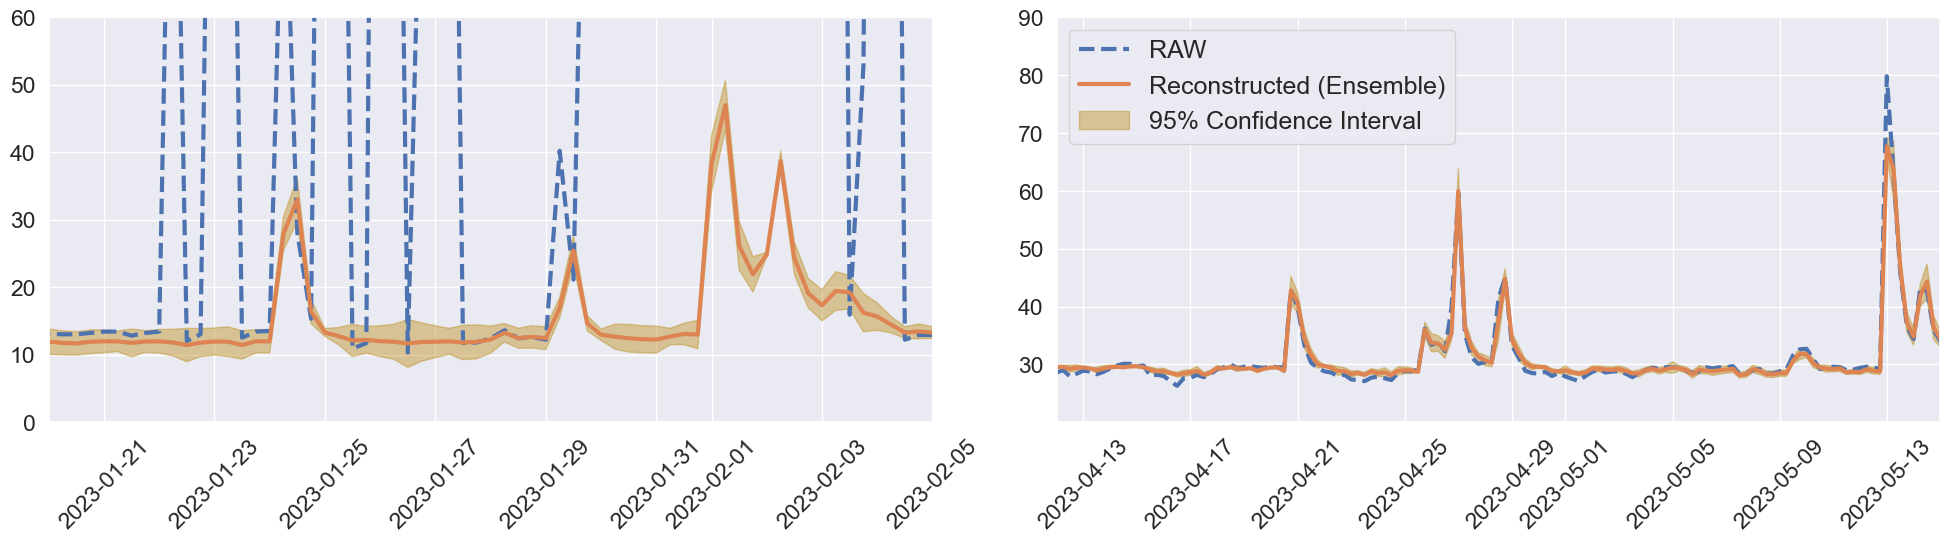

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[1].plot(y_test.index, y_test['bridge4'], '--', lw = 3, label = 'RAW')
ax[1].plot(y.index, ensemble_predictions[:,0], lw = 3, label = 'Reconstructed (Ensemble)')
ax[1].fill_between(y.index, lower_bound[:,0], upper_bound[:,0], alpha=0.4, color = 'darkgoldenrod', label='95% Confidence Interval')
ax[1].set_xlim([pd.to_datetime('2023-04-12'), pd.to_datetime('2023-05-15')])

ax[0].plot(y.index, y['bridge5'], '--', lw = 3, label = 'RAW')
ax[0].plot(y.index, ensemble_predictions[:,1], lw = 3, label = 'Reconstructed (Ensemble)')
ax[0].fill_between(y.index, lower_bound[:,1], upper_bound[:,1], alpha=0.4, color = 'darkgoldenrod', label='95% Confidence Interval')
ax[0].set_xlim([pd.to_datetime('2023-01-20'), pd.to_datetime('2023-02-05')])
ax[0].set_ylim([0, 60])
plt.tight_layout()

# Adjust the x-labels on both subplots
ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)
plt.legend(fontsize = 18)